In [4]:
# %pip install -r ../requirements.txt

# Transformer Attention 理解ガイド

このノートブックでは、Transformerの核心である**Attention機構**を段階的に学びます。

### 学習内容
1. 文章理解のプロセス
2. 文章生成のプロセス


## 文章理解のプロセス

### ステップ０: 前準備。必要なライブラリのインポートや日本語フォントのセットアップ

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import matplotlib.font_manager as fm
import platform

# 日本語フォント設定
if platform.system() == 'Darwin':  # macOS
    japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic ProN', 'Yu Gothic']
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    for font in japanese_fonts:
        if font in available_fonts:
            rcParams['font.family'] = font
            break
else:
    rcParams['font.family'] = 'sans-serif'

print("✅ ライブラリのインポート完了")
print(f"使用フォント: {rcParams['font.family']}")

✅ ライブラリのインポート完了
使用フォント: ['Hiragino Sans']


### ステップ１: サンプルデータ（文章）の準備

まず、簡単な日本語文を扱うための**語彙辞書**と**トークナイザー**を作ります。<br>
sample_text = "私が公園を歩いているとき向こうから犬が歩いてきた。私はその犬を見た。"<br>
sample_words = ['私', 'が', '公園', 'を', '歩いて', 'いる', 'と', '向こう', 'から', '犬', 'が', '歩いてきた', '。', '私', 'は', 'その', '犬', 'を', '見た', '。']


In [8]:
# 語彙辞書の作成
vocab = {
    '私': 0, 'が': 1, '公園': 2, 'を': 3, '歩いて': 4, 'いる': 5, 'と': 6,
    '向こう': 7, 'から': 8, '犬': 9, '歩いてきた': 10, '。': 11,
    'は': 12, 'その': 13, '見た': 14, '[END]': 15,
    'について': 16, '教えて': 17, '哺乳類': 18, 'で': 19, 'す': 20
}

# 逆引き辞書（IDから単語へ）
id_to_word = {v: k for k, v in vocab.items()}

# サンプル文章
sample_text = "私が公園を歩いているとき向こうから犬が歩いてきた。私はその犬を見た。"
sample_words = ['私', 'が', '公園', 'を', '歩いて', 'いる', 'と', '向こう', 
                'から', '犬', 'が', '歩いてきた', '。', 
                '私', 'は', 'その', '犬', 'を', '見た', '。']

print(f"📝 サンプル文: {sample_text}")
print(f"\n🔤 トークン分割結果:")
for i, word in enumerate(sample_words):
    print(f"  [{i:2d}] {word}")

📝 サンプル文: 私が公園を歩いているとき向こうから犬が歩いてきた。私はその犬を見た。

🔤 トークン分割結果:
  [ 0] 私
  [ 1] が
  [ 2] 公園
  [ 3] を
  [ 4] 歩いて
  [ 5] いる
  [ 6] と
  [ 7] 向こう
  [ 8] から
  [ 9] 犬
  [10] が
  [11] 歩いてきた
  [12] 。
  [13] 私
  [14] は
  [15] その
  [16] 犬
  [17] を
  [18] 見た
  [19] 。


## Attentionとは何か？

### 基本概念

「Attention（注意機構）」は、ある単語を理解する際に、**他のどの単語に注目すべきか**を決める仕組みです。

例えば、
- 「**その**犬」の「その」を理解するには → 前に出てきた「犬」に注目する必要がある
- 「犬**を**見た」の「を」を理解するには → 「犬」と「見た」の関係に注目する必要がある

### 3つの重要な概念

1. **Query（クエリ）**: 「今理解したい単語」からの問いかけ
2. **Key（キー）**: 各単語が持つ「検索用の特徴」
3. **Value（バリュー）**: 各単語が持つ「実際の情報」

→ Queryで各Keyを検索し、マッチ度に応じてValueを重み付けして統合する

### ステップ２: Attentionスコアの計算

ここでは簡易的なルールベースでAttentionスコアを計算します。
（実際のTransformerでは学習されたパラメータで計算）

In [9]:
def compute_attention_scores(query_word, all_words, query_idx):
    """
    Attentionスコアを計算（擬似的）
    
    Parameters:
    - query_word: 注目している単語
    - all_words: 全単語のリスト
    - query_idx: query_wordのインデックス
    
    Returns:
    - scores: 正規化されたAttentionスコア（合計=1）
    """
    scores = np.zeros(len(all_words))
    
    for i, word in enumerate(all_words):
        # 【重要】Causal Masking: 未来の単語は見えない
        if i > query_idx:
            scores[i] = 0
            continue
        
        # 意味的・文法的な関連性に基づくスコア設定
        if query_word == 'その' and word == '犬' and i < query_idx:
            scores[i] = 0.8  # 指示語は前の名詞を参照
        elif query_word == '犬' and word in ['を', 'が']:
            scores[i] = 0.6  # 格助詞との関連
        elif query_word == 'を' and word == '見た':
            scores[i] = 0.9  # 目的語と動詞
        elif query_word == '見た' and word in ['犬', 'を']:
            scores[i] = 0.7  # 動詞と目的語
        elif query_word == word:
            scores[i] = 0.5  # 自分自身
        elif abs(i - query_idx) == 1:
            scores[i] = 0.4  # 隣接単語
        elif abs(i - query_idx) <= 3:
            scores[i] = 0.2  # 近い単語
        else:
            scores[i] = 0.1  # 遠い単語
    
    # Softmax的な正規化（合計を1にする）
    scores = scores / (np.sum(scores) + 1e-10)
    return scores

# テスト: 「その」が他の単語に注目する度合い
test_idx = 15  # 「その」のインデックス
test_word = sample_words[test_idx]
test_scores = compute_attention_scores(test_word, sample_words, test_idx)

print(f"🔍 '{test_word}' が各単語に注目する度合い:\n")
for i, (word, score) in enumerate(zip(sample_words, test_scores)):
    if score > 0.01:  # 有意なスコアのみ表示
        bar = '█' * int(score * 50)  # 視覚的なバー
        print(f"  [{i:2d}] {word:8s} {score:.3f} {bar}")

🔍 'その' が各単語に注目する度合い:

  [ 0] 私        0.031 █
  [ 1] が        0.031 █
  [ 2] 公園       0.031 █
  [ 3] を        0.031 █
  [ 4] 歩いて      0.031 █
  [ 5] いる       0.031 █
  [ 6] と        0.031 █
  [ 7] 向こう      0.031 █
  [ 8] から       0.031 █
  [ 9] 犬        0.250 ████████████
  [10] が        0.031 █
  [11] 歩いてきた    0.031 █
  [12] 。        0.062 ███
  [13] 私        0.062 ███
  [14] は        0.125 ██████
  [15] その       0.156 ███████


### 💭 結果の解釈

「**その**」という指示語は、以前に出てきた「**犬**」（インデックス9）に最も強く注目していることがわかります！

これがAttentionの本質です。

### ステップ３: 文章全体のAttentionマップ

すべての単語について、他の単語への注目度を計算し、ヒートマップで可視化します。

In [10]:
# 全単語のAttentionマトリックスを計算
n_words = len(sample_words)
attention_matrix = np.zeros((n_words, n_words))

for i, query_word in enumerate(sample_words):
    scores = compute_attention_scores(query_word, sample_words, i)
    attention_matrix[i, :] = scores

print(f"✅ Attentionマトリックス作成完了: {attention_matrix.shape}")
print(f"   各行 = 1つの単語からの視点")
print(f"   各列 = 参照される単語")

✅ Attentionマトリックス作成完了: (20, 20)
   各行 = 1つの単語からの視点
   各列 = 参照される単語


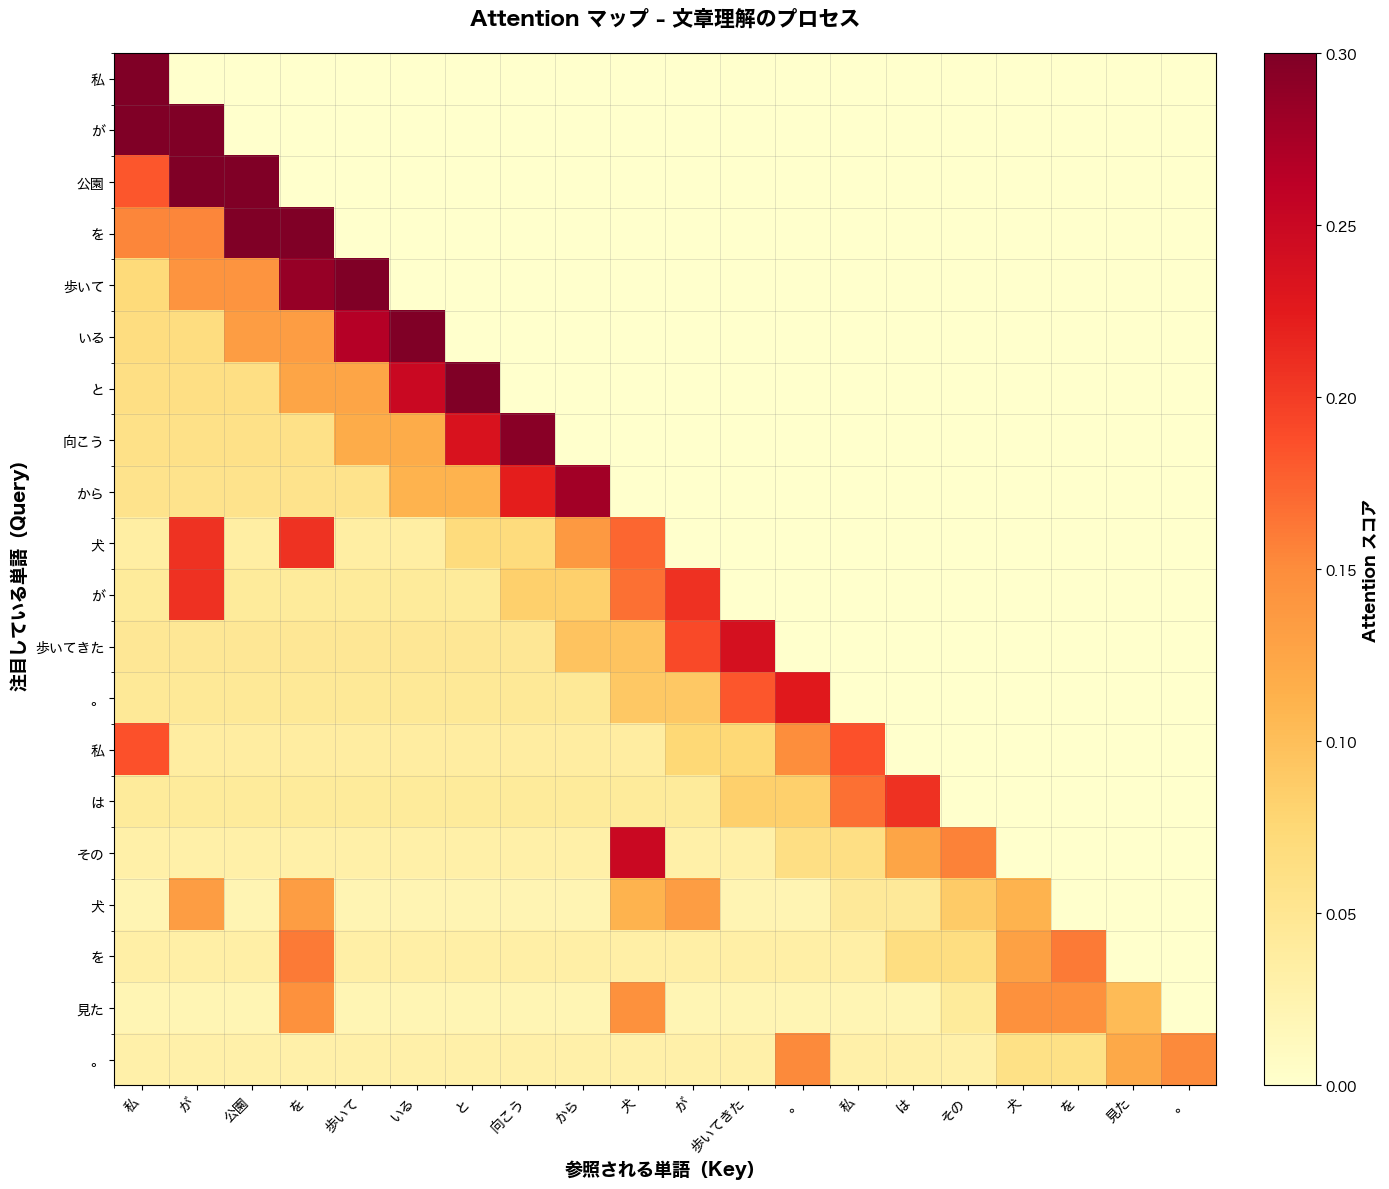


📊 ヒートマップの読み方:
  - 濃い色 = 強い注目
  - 右上の三角形が白い = Causal Masking（未来は見えない）
  - 対角線が濃い = 自分自身への注目


In [11]:
# 可視化
fig, ax = plt.subplots(figsize=(14, 12))

# ヒートマップ
im = ax.imshow(attention_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.3)

# 軸ラベル
ax.set_xticks(range(n_words))
ax.set_yticks(range(n_words))
ax.set_xticklabels(sample_words, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(sample_words, fontsize=10)

ax.set_xlabel('参照される単語（Key）', fontsize=13, fontweight='bold')
ax.set_ylabel('注目している単語（Query）', fontsize=13, fontweight='bold')
ax.set_title('Attention マップ - 文章理解のプロセス', fontsize=15, fontweight='bold', pad=20)

# カラーバー
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Attention スコア', fontsize=12, fontweight='bold')

# グリッド
ax.set_xticks(np.arange(n_words) - 0.5, minor=True)
ax.set_yticks(np.arange(n_words) - 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 ヒートマップの読み方:")
print("  - 濃い色 = 強い注目")
print("  - 右上の三角形が白い = Causal Masking（未来は見えない）")
print("  - 対角線が濃い = 自分自身への注目")

### ステップ４: 特定の単語の詳細分析

「**その**」という単語が他の単語にどう注目しているか、詳しく見てみましょう。

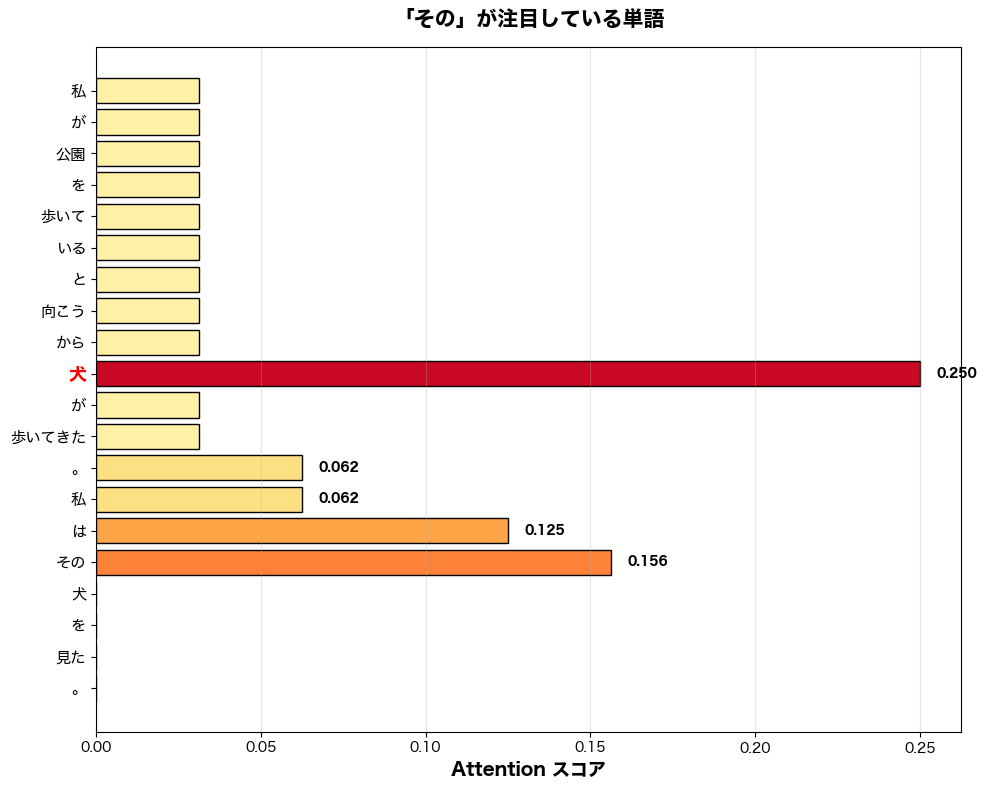


🎯 結果: 「その」は「犬」に最も強く注目しています！


In [12]:
# 「その」のAttentionを詳しく見る
target_idx = 15
target_word = sample_words[target_idx]
target_scores = attention_matrix[target_idx, :]

fig, ax = plt.subplots(figsize=(10, 8))

# カラーマップに基づく色付け
colors = plt.cm.YlOrRd(target_scores / 0.3)
bars = ax.barh(range(n_words), target_scores, color=colors, edgecolor='black', linewidth=1)

ax.set_yticks(range(n_words))
ax.set_yticklabels(sample_words, fontsize=11)
ax.set_xlabel('Attention スコア', fontsize=13, fontweight='bold')
ax.set_title(f'「{target_word}」が注目している単語', fontsize=15, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 最も注目している単語を強調
max_idx = np.argmax(target_scores[:target_idx])  # 自分より前の単語のみ
ax.get_yticklabels()[max_idx].set_color('red')
ax.get_yticklabels()[max_idx].set_fontweight('bold')
ax.get_yticklabels()[max_idx].set_fontsize(13)

# スコア値を表示
for i, (bar, score) in enumerate(zip(bars, target_scores)):
    if score > 0.05:
        ax.text(score + 0.005, i, f'{score:.3f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎯 結果: 「{target_word}」は「{sample_words[max_idx]}」に最も強く注目しています！")

---

## 文章生成のプロセス

次は、Transformerがどうやって**新しい文章を生成するか**を見ていきます。

### タスク
入力: 「犬について教えて」  
出力: 「犬は哺乳類です」

このプロセスを**1単語ずつ**生成する様子を可視化します。

In [13]:
# 生成タスクの設定
input_words = ['犬', 'について', '教えて']
generated_words = ['犬', 'は', '哺乳類', 'で', 'す']

print("📝 文章生成タスク")
print(f"  入力: {' '.join(input_words)}")
print(f"  目標出力: {' '.join(generated_words)}")
print(f"\n  → これを1単語ずつ生成していきます！")

📝 文章生成タスク
  入力: 犬 について 教えて
  目標出力: 犬 は 哺乳類 で す

  → これを1単語ずつ生成していきます！


### ステップ１: 最初の単語「犬」を生成

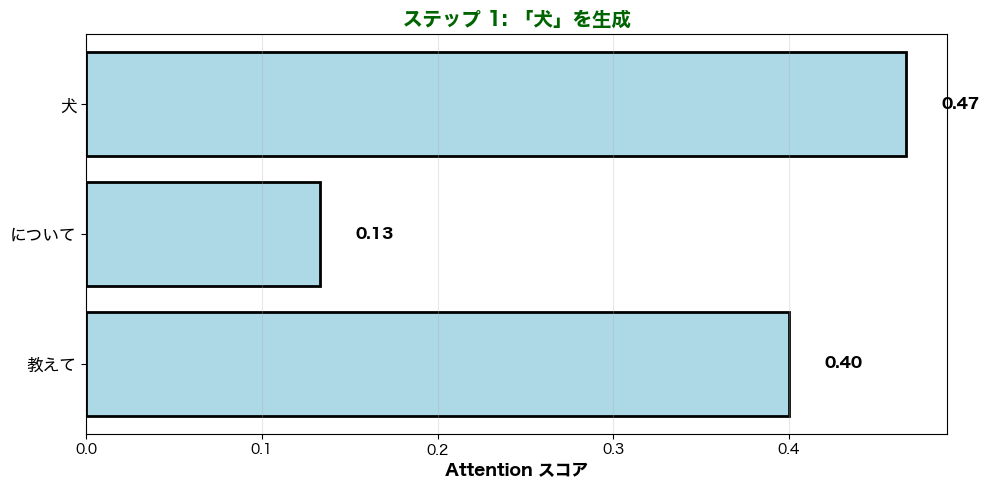

💡 解釈: 入力の「犬」と「教えて」に注目して、最初の単語「犬」を生成


In [14]:
# ステップ1: 「犬」を生成
step = 0
context = input_words + generated_words[:step]  # まだ何も生成していない
current_word = generated_words[step]

# Attentionスコアを設定（ルールベース）
scores_step1 = np.array([0.7, 0.2, 0.6])  # [犬, について, 教えて]
scores_step1 = scores_step1 / scores_step1.sum()

# 可視化
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['lightblue'] * len(input_words)
bars = ax.barh(range(len(context)), scores_step1, color=colors, edgecolor='black', linewidth=2)

ax.set_yticks(range(len(context)))
ax.set_yticklabels(context, fontsize=12)
ax.set_xlabel('Attention スコア', fontsize=12, fontweight='bold')
ax.set_title(f'ステップ {step+1}: 「{current_word}」を生成', fontsize=14, fontweight='bold', color='darkgreen')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# スコア表示
for i, (bar, score) in enumerate(zip(bars, scores_step1)):
    ax.text(score + 0.02, i, f'{score:.2f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"💡 解釈: 入力の「犬」と「教えて」に注目して、最初の単語「{current_word}」を生成")

### ステップ２: 次の単語「は」を生成

今度は、入力 + 生成済みの「犬」をコンテキストとして使います。

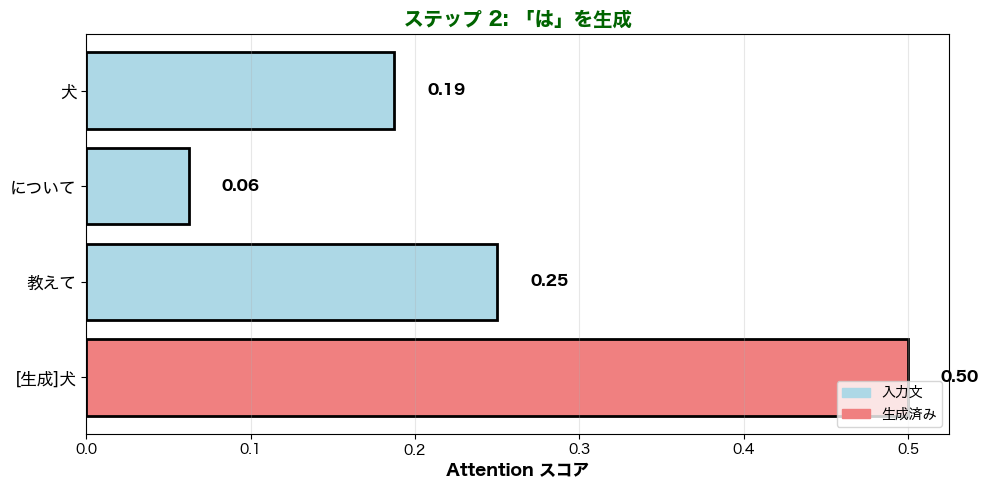

💡 解釈: 生成した「犬」に最も強く注目して、助詞「は」を生成


In [15]:
# ステップ2: 「は」を生成
step = 1
context = input_words + generated_words[:step]
current_word = generated_words[step]

scores_step2 = np.array([0.3, 0.1, 0.4, 0.8])  # [犬, について, 教えて, [生成]犬]
scores_step2 = scores_step2 / scores_step2.sum()

# 可視化
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['lightblue'] * 3 + ['lightcoral'] * 1  # 生成済みは赤色
bars = ax.barh(range(len(context)), scores_step2, color=colors, edgecolor='black', linewidth=2)

labels = input_words + [f"[生成]{w}" for w in generated_words[:step]]
ax.set_yticks(range(len(context)))
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel('Attention スコア', fontsize=12, fontweight='bold')
ax.set_title(f'ステップ {step+1}: 「{current_word}」を生成', fontsize=14, fontweight='bold', color='darkgreen')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, scores_step2)):
    ax.text(score + 0.02, i, f'{score:.2f}', va='center', fontsize=11, fontweight='bold')

# 凡例
blue_patch = mpatches.Patch(color='lightblue', label='入力文')
red_patch = mpatches.Patch(color='lightcoral', label='生成済み')
ax.legend(handles=[blue_patch, red_patch], loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"💡 解釈: 生成した「犬」に最も強く注目して、助詞「{current_word}」を生成")

### 全ステップの一覧表示

/var/folders/p_/5r0lvdds1w18dg5v_3fhgdt40000gn/T/ipykernel_14770/1249282366.py:40: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) Hiragino Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) Hiragino Sans.
  fig.canvas.print_figure(bytes_io, **kw)


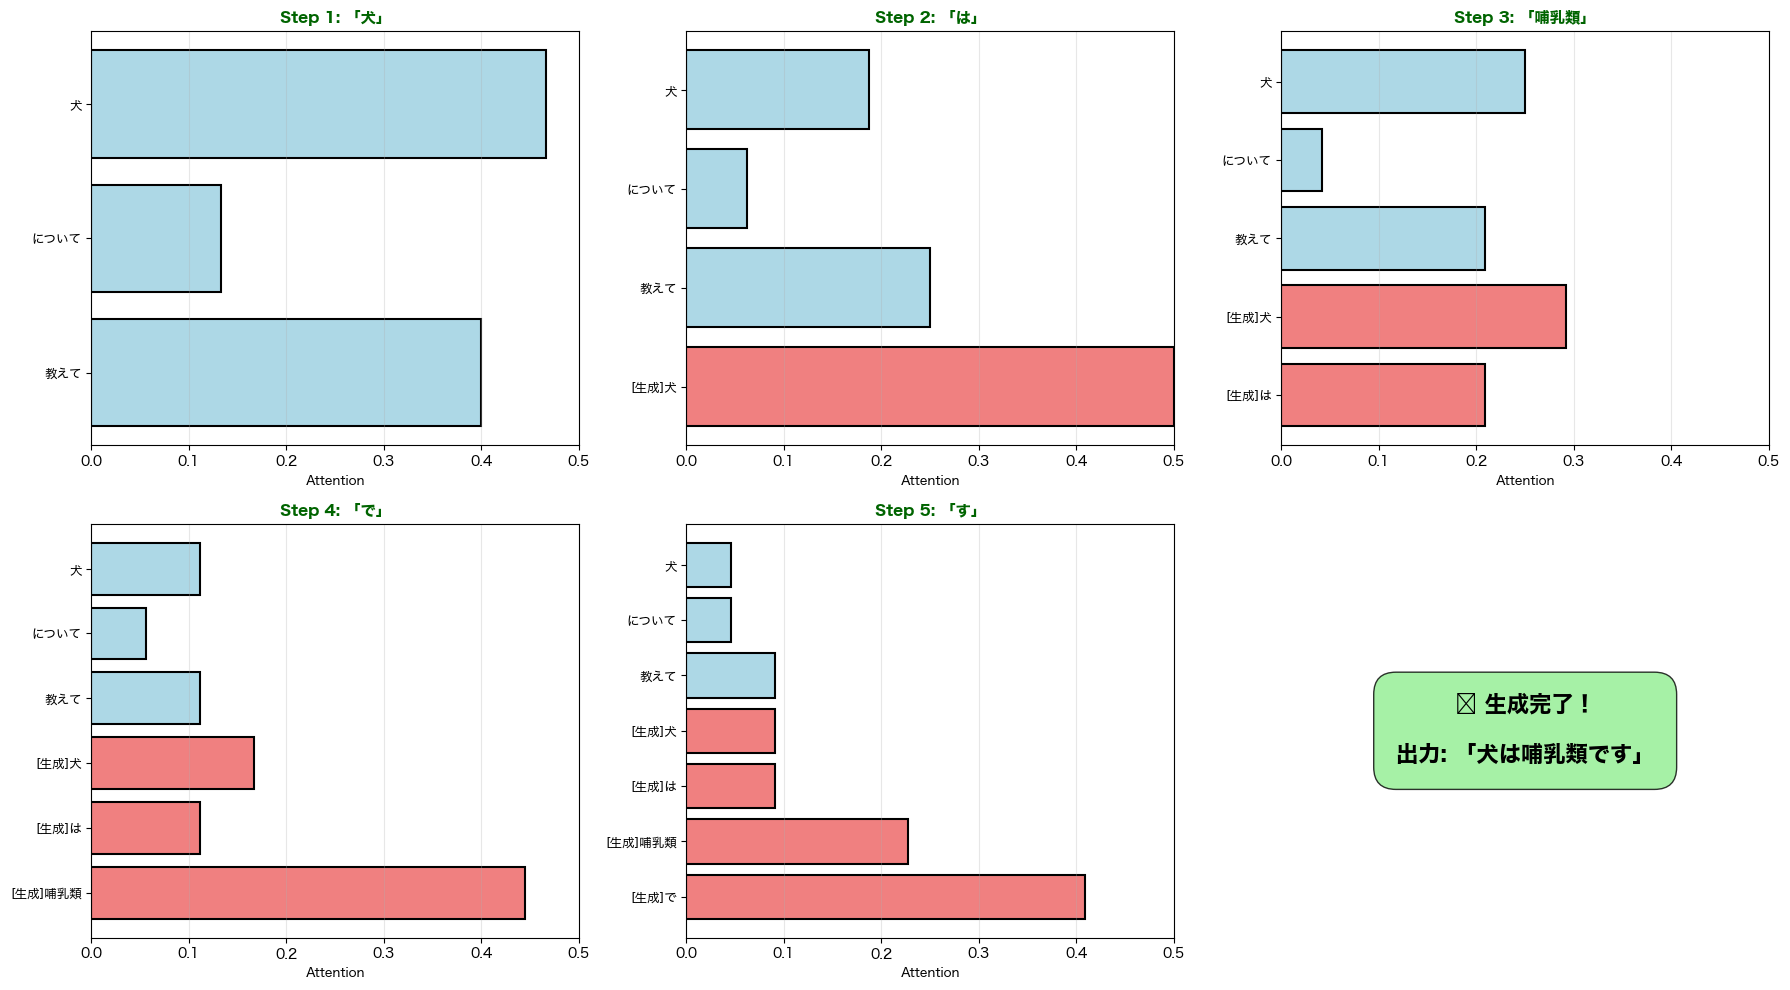


✅ 文章生成プロセスの全体像が完成しました！


In [16]:
# 全5ステップを一度に可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 各ステップのAttentionスコア（ルールベース）
all_scores = [
    np.array([0.7, 0.2, 0.6]),
    np.array([0.3, 0.1, 0.4, 0.8]),
    np.array([0.6, 0.1, 0.5, 0.7, 0.5]),
    np.array([0.2, 0.1, 0.2, 0.3, 0.2, 0.8]),
    np.array([0.1, 0.1, 0.2, 0.2, 0.2, 0.5, 0.9])
]

for step in range(5):
    ax = axes[step]
    context = input_words + generated_words[:step]
    current_word = generated_words[step]
    
    scores = all_scores[step]
    scores = scores / scores.sum()
    
    colors = ['lightblue'] * len(input_words) + ['lightcoral'] * step
    bars = ax.barh(range(len(context)), scores, color=colors, edgecolor='black', linewidth=1.5)
    
    labels = input_words + [f"[生成]{w}" for w in generated_words[:step]]
    ax.set_yticks(range(len(context)))
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Attention', fontsize=9)
    ax.set_title(f'Step {step+1}: 「{current_word}」', fontsize=11, fontweight='bold', color='darkgreen')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, 0.5)

# 最後のパネルは完成メッセージ
axes[5].axis('off')
axes[5].text(0.5, 0.5, '🎉 生成完了！\n\n出力: 「犬は哺乳類です」', 
            ha='center', va='center', fontsize=16, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, pad=1))

plt.tight_layout()
plt.show()

print("\n✅ 文章生成プロセスの全体像が完成しました！")

---

## Query-Key-Value の詳細メカニズム

最後に、Attentionの核心である**Query-Key-Value機構**を深く理解しましょう。

### 🔑 3つの要素の役割

図書館の例え:
- **Query**: 「探している情報の特徴」（例: 「犬に関する本」）
- **Key**: 各本の「タイトル・分類番号」（検索用）
- **Value**: 各本の「実際の内容」（取得する情報）

→ Queryで各Keyを検索 → マッチ度が高いKeyのValueを重視して統合

In [20]:
#「哺乳類」を生成する過程
context_words = ['犬', 'について', '教えて', '犬', 'は']
next_word = '哺乳類'

# Attentionスコア
attention_scores = np.array([0.6, 0.2, 0.5, 0.7, 0.5])
attention_scores = attention_scores / attention_scores.sum()

print("🔍 生成ステップの詳細分析")
print(f"  コンテキスト: {' / '.join(context_words)}")
print(f"  生成する単語: {next_word}")
print(f"\n  各単語へのAttention:")
for word, score in zip(context_words, attention_scores):
    print(f"    {word:8s} → {score:.3f}")

🔍 生成ステップの詳細分析
  コンテキスト: 犬 / について / 教えて / 犬 / は
  生成する単語: 哺乳類

  各単語へのAttention:
    犬        → 0.240
    について     → 0.080
    教えて      → 0.200
    犬        → 0.280
    は        → 0.200


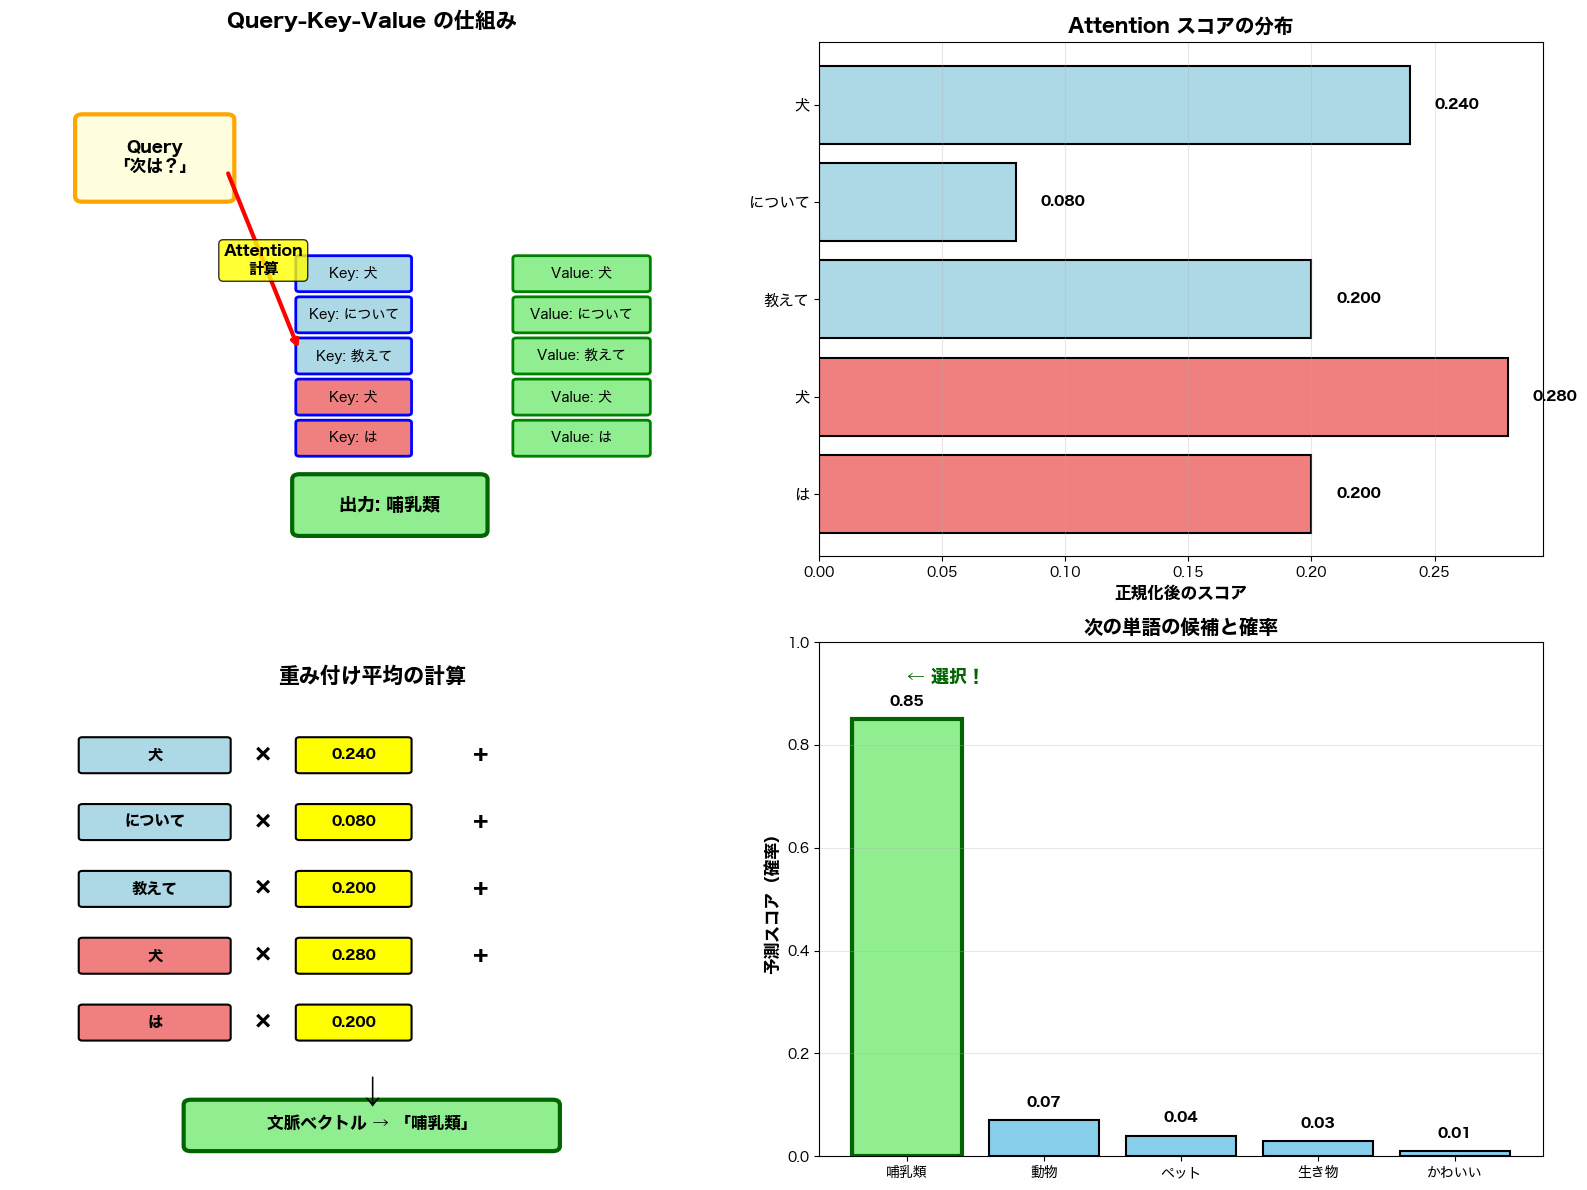


✅ Query-Key-Value メカニズムの完全な流れを可視化しました！


In [18]:
# Query-Key-Value の概念図
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ========== サブプロット1: Query-Key-Value の構造 ==========
ax1 = axes[0, 0]
ax1.axis('off')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)

# Query
rect_q = mpatches.FancyBboxPatch((1, 7), 2, 1.5, boxstyle="round,pad=0.1", 
                                 edgecolor='orange', facecolor='lightyellow', linewidth=3)
ax1.add_patch(rect_q)
ax1.text(2, 7.75, 'Query\n「次は？」', ha='center', va='center', fontsize=12, fontweight='bold')

# Keys
for i, word in enumerate(context_words):
    y_pos = 5.5 - i * 0.8
    color = 'lightblue' if i < 3 else 'lightcoral'
    rect = mpatches.FancyBboxPatch((4, y_pos-0.3), 1.5, 0.6, boxstyle="round,pad=0.05",
                                  edgecolor='blue', facecolor=color, linewidth=2)
    ax1.add_patch(rect)
    ax1.text(4.75, y_pos, f'Key: {word}', ha='center', va='center', fontsize=10)

# Attention計算の矢印
ax1.annotate('', xy=(4, 4), xytext=(3, 7.5),
            arrowprops=dict(arrowstyle='->', lw=3, color='red'))
ax1.text(3.5, 5.5, 'Attention\n計算', ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Values
for i, word in enumerate(context_words):
    y_pos = 5.5 - i * 0.8
    rect = mpatches.FancyBboxPatch((7, y_pos-0.3), 1.8, 0.6, boxstyle="round,pad=0.05",
                                  edgecolor='green', facecolor='lightgreen', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(7.9, y_pos, f'Value: {word}', ha='center', va='center', fontsize=10)

# 出力
rect_out = mpatches.FancyBboxPatch((4, 0.5), 2.5, 1, boxstyle="round,pad=0.1",
                                  edgecolor='darkgreen', facecolor='lightgreen', linewidth=3)
ax1.add_patch(rect_out)
ax1.text(5.25, 1, f'出力: {next_word}', ha='center', va='center', fontsize=13, fontweight='bold')

ax1.set_title('Query-Key-Value の仕組み', fontsize=15, fontweight='bold', pad=10)

# ========== サブプロット2: Attentionスコアの分布 ==========
ax2 = axes[0, 1]
colors_bar = ['lightblue'] * 3 + ['lightcoral'] * 2
bars = ax2.barh(range(len(context_words)), attention_scores, color=colors_bar, 
                edgecolor='black', linewidth=1.5)

ax2.set_yticks(range(len(context_words)))
ax2.set_yticklabels(context_words, fontsize=11)
ax2.set_xlabel('正規化後のスコア', fontsize=12, fontweight='bold')
ax2.set_title('Attention スコアの分布', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, attention_scores)):
    ax2.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=10, fontweight='bold')

# ========== サブプロット3: 重み付け平均の計算 ==========
ax3 = axes[1, 0]
ax3.axis('off')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)

ax3.text(5, 9.2, '重み付け平均の計算', ha='center', fontsize=15, fontweight='bold')

y_start = 7.8
for i, (word, score) in enumerate(zip(context_words, attention_scores)):
    y = y_start - i * 1.3
    color = 'lightblue' if i < 3 else 'lightcoral'
    
    # Value box
    rect = mpatches.FancyBboxPatch((1, y-0.3), 2, 0.6, boxstyle="round,pad=0.05",
                                  facecolor=color, edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect)
    ax3.text(2, y, word, ha='center', va='center', fontsize=11, fontweight='bold')
    
    # 掛け算
    ax3.text(3.5, y, '×', ha='center', va='center', fontsize=16, fontweight='bold')
    
    # スコア
    rect2 = mpatches.FancyBboxPatch((4, y-0.3), 1.5, 0.6, boxstyle="round,pad=0.05",
                                   facecolor='yellow', edgecolor='black', linewidth=1.5)
    ax3.add_patch(rect2)
    ax3.text(4.75, y, f'{score:.3f}', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # 足し算記号
    if i < len(context_words) - 1:
        ax3.text(6.5, y, '+', ha='center', va='center', fontsize=16, fontweight='bold')

# 結果
ax3.text(5, 1.2, '↓', ha='center', va='center', fontsize=24, fontweight='bold')
result_box = mpatches.FancyBboxPatch((2.5, 0.2), 5, 0.8, boxstyle="round,pad=0.1",
                                    facecolor='lightgreen', edgecolor='darkgreen', linewidth=3)
ax3.add_patch(result_box)
ax3.text(5, 0.6, f'文脈ベクトル → 「{next_word}」', ha='center', va='center', 
        fontsize=12, fontweight='bold')

# ========== サブプロット4: 次の単語の予測 ==========
ax4 = axes[1, 1]

candidates = ['哺乳類', '動物', 'ペット', '生き物', 'かわいい']
candidate_scores = [0.85, 0.07, 0.04, 0.03, 0.01]

bars = ax4.bar(candidates, candidate_scores, color='skyblue', edgecolor='black', linewidth=1.5)
bars[0].set_color('lightgreen')
bars[0].set_edgecolor('darkgreen')
bars[0].set_linewidth(3)

ax4.set_ylabel('予測スコア（確率）', fontsize=12, fontweight='bold')
ax4.set_title('次の単語の候補と確率', fontsize=14, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, candidate_scores)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4.text(0, 0.92, '← 選択！', fontsize=13, fontweight='bold', color='darkgreen')

plt.tight_layout()
plt.show()

print("\n✅ Query-Key-Value メカニズムの完全な流れを可視化しました！")

---

## まとめ

### 学んだこと

1. **Attentionの本質**
   - ある単語を理解・生成する際に、他のどの単語に注目すべきかを決める機構
   - スコアは学習によって獲得される（今回はルールベースで擬似）

2. **Query-Key-Valueの仕組み**
   - Query: 「探している情報」
   - Key: 「検索用の特徴」
   - Value: 「実際の情報」
   - 類似度の高いValueを重み付けして統合

3. **Causal Masking**
   - 文章生成時、未来の単語は見えない
   - これにより左から右へ順序通り生成

4. **文章生成の逐次性**
   - 1単語ずつ生成
   - 生成済みの単語もコンテキストに追加
   - 各ステップでAttentionを再計算

### 実際のTransformerとの違い

- 今回: ルールベースの簡易版
- 実際: ニューラルネットで学習されたパラメータで計算
- 実際: Multi-head Attention（複数の視点から注目）
- 実際: Position Encoding（単語の位置情報）
- 実際: 膨大な語彙・巨大なモデル

---

### さらに学ぶには

- 論文: "Attention is All You Need" (Vaswani et al., 2017)
- PyTorchで実装してみる
- 事前学習モデル（BERT/GPT）のAttentionを可視化
